# Image orientation analysis tutorial

In [115]:
import matplotlib.pyplot as plt
from OFT_funcs import *
from skimage import measure, filters
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter, median_filter
import matplotlib.patches as mpatch

## Raw image

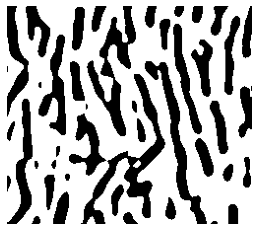

In [86]:
img = io.imread(r'..\img\testFT_1.tif', as_gray=True)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.savefig(r'E:\Github\PhD-thesis\Figs\A-2\oft-1.pdf')

## Fourier transform of the image above

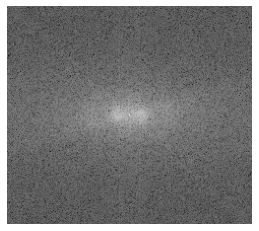

In [87]:
fft = np.log(abs(np.fft.fft2(img)))
sfft = np.fft.fftshift(fft)
plt.imshow(sfft, cmap='gray')
plt.axis('off')
plt.savefig(r'E:\Github\PhD-thesis\Figs\A-2\oft-2.pdf')

## Smooth the FT image

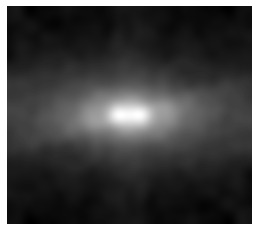

In [109]:
smooth = gaussian_filter(sfft, 5)
plt.imshow(smooth, cmap='gray')
plt.axis('off')
plt.savefig(r'E:\Github\PhD-thesis\Figs\A-2\oft-3.pdf')

## Threshold the FFT image

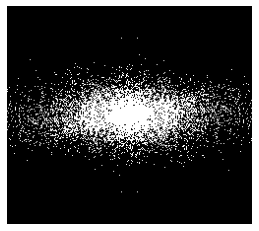

In [108]:
thres = sfft > filters.threshold_yen(smooth)
plt.imshow(thres, cmap='gray')
plt.axis('off')
plt.savefig(r'E:\Github\PhD-thesis\Figs\A-2\oft-4.pdf')

## Despeckle the signal above

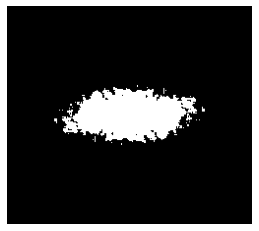

In [112]:
despeck = median_filter(thres, size=5)
plt.imshow(despeck, cmap='gray')
plt.axis('off')
plt.savefig(r'E:\Github\PhD-thesis\Figs\A-2\oft-5.pdf')

## Detect the orientation of the FT pattern

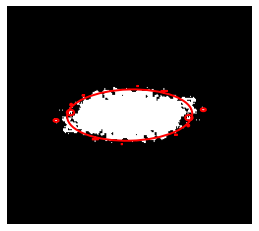

In [123]:
label_img = measure.label(despeck)
prop = measure.regionprops_table(label_img, properties=['area', 'major_axis_length', 'minor_axis_length', 'orientation', 'centroid'])
prop_df = pd.DataFrame(prop)
fig, ax = plt.subplots()
ax.imshow(despeck, cmap='gray')
for num, i in prop_df.iterrows():
    elli = mpatch.Ellipse((i['centroid-1'], i['centroid-0']), i.major_axis_length, i.minor_axis_length, angle=i.orientation,
                          fc=(0,0,0,0), ec='red', lw=2)
    ax.add_patch(elli)
ax.axis('off')
fig.savefig(r'E:\Github\PhD-thesis\Figs\A-2\oft-6.pdf')

In [124]:
main_feature = prop_df.sort_values(by='area', ascending=False).iloc[0]

In [128]:
prop_df.head()

,area,major_axis_length,minor_axis_length,orientation,centroid-0,centroid-1
0,2,2.000000,0.000000,0.000000,80.5,132.0
1,4945,127.152514,52.065234,-1.524223,110.0,124.0
2,1,0.000000,0.000000,0.785398,82.0,142.0
3,6,6.831301,0.000000,0.000000,85.5,159.0
4,1,0.000000,0.000000,0.785398,85.0,161.0


The main feature in FFT is always perpendicular to the dominant orientation of the original image.

(-0.5, 959.5, 1279.5, -0.5)

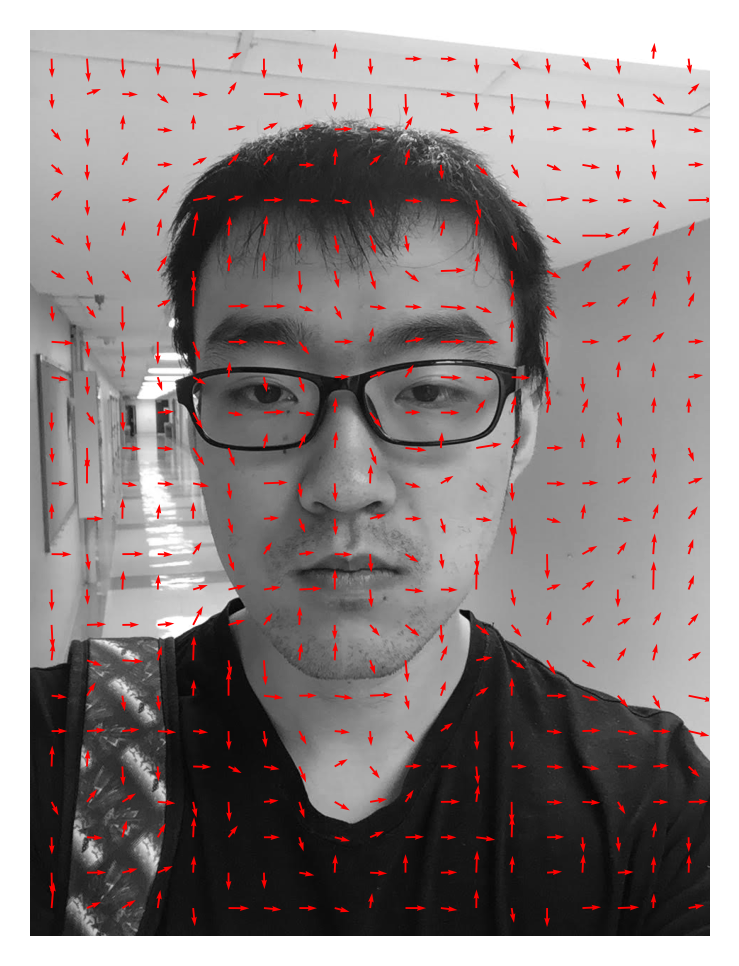

In [153]:
windowShape = (50, 50)
img = io.imread(r'..\img\testFT_4.jpg', as_gray=True)
##################
X, Y = sectionWindow(img.shape, windowShape)
y = X[0:X.size-1] + windowShape[0]/2
x = Y[0:Y.size-1] + windowShape[1]/2
x, y = np.meshgrid(x, y)
u_ori = x.copy()
v_ori = y.copy()
for i in range(0, x.shape[0]): # col
    for j in range(0, y.shape[1]): # row
        window = img[X[i]:X[i+1], Y[j]:Y[j+1]]
        fft = np.log(abs(np.fft.fft2(window)))
        fft = np.fft.fftshift(fft)
        smooth = gaussian_filter(fft, 5)
        thres = smooth > filters.threshold_isodata(smooth)
        despeck = median_filter(thres, size=5)
        ori, orim = getOrientation(despeck)
        u_ori[i, j] = orim*math.cos(ori)
        v_ori[i, j] = orim*math.sin(ori)
        
plt.figure(dpi=300)
plt.imshow(img, cmap='gray')
plt.quiver(x, y, u_ori, v_ori, color='red') 
plt.axis('off')
# plt.savefig(r'E:\Github\PhD-thesis\Figs\A-2\oft-g3.pdf')

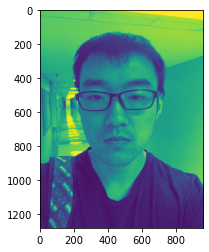

In [55]:
plt.imshow(img)

In [58]:
thres = img > filters.threshold_mean(img)

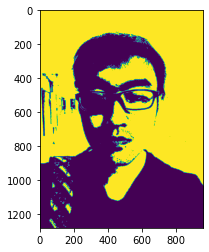

In [59]:
plt.imshow(thres)

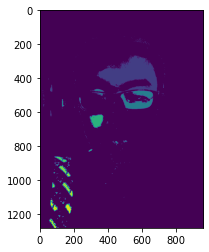

In [61]:
plt.imshow(label_img)

In [60]:
label_img = measure.label(thres)

In [62]:
prop = measure.regionprops_table(label_img, properties=['area', 'major_axis_length', 'minor_axis_length', 'orientation'])

In [63]:
prop_df = pd.DataFrame(prop)

In [67]:
len(prop_df)

481

In [66]:
prop_df.sort_values(by='area', ascending=False)

,area,major_axis_length,minor_axis_length,orientation
0,611756,1286.497411,1181.059754,0.906409
86,38329,354.029385,182.970940,-1.552043
203,10089,203.895654,125.155327,-1.338957
306,4226,78.603149,72.602945,-0.482333
456,1114,55.149084,28.512676,0.348861
...,...,...,...,...
285,1,0.000000,0.000000,0.785398
286,1,0.000000,0.000000,0.785398
289,1,0.000000,0.000000,0.785398
291,1,0.000000,0.000000,0.785398


rewrite getOrientation function

In [130]:
def getOrientation(bw_img):
    label_img = measure.label(thres)
    prop = measure.regionprops_table(label_img, properties=['area', 'major_axis_length', 'minor_axis_length', 'orientation'])
    prop_df = pd.DataFrame(prop)
    if len(prop_df) == 0:
        return 0, 0
    else:
        main_feature = prop_df.sort_values(by='area', ascending=False).iloc[0]
        return main_feature.orientation, main_feature.major_axis_length/main_feature.minor_axis_length

In [11]:
def getOrientation(bw_img):
    label_img = label(thres).transpose()
    region = regionprops(label_img, coordinates='rc')
    area = 0
    num_max = 0
    for num in range(0, len(region)):
        area_tmp = region[num]['area']
        maj_tmp = region[num]['major_axis_length']
        min_tmp = region[num]['minor_axis_length']
        ori_tmp = region[num]['orientation']
        if area_tmp > area:
            area = area_tmp
            num_max = num
    maj = region[num_max]['major_axis_length']
    min = region[num_max]['minor_axis_length']
    ori = region[num_max]['orientation']
    img_ori = ori + math.pi/2
    # if img_ori > math.pi:
        # img_ori = img_ori - math.pi
    img_ori_magnitude = maj/min
    return img_ori, img_ori_magnitude